# Task 4 Time Series Analysis
*Alberto Roberto Marinelli, Giacomo Cignoni, Alessandro Bucci*
## Importing Libraries
First we import the libraries necessary to extract the time series


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax, TimeSeriesResampler
from statsmodels.tsa.stattools import adfuller 

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df = pd.read_csv("../dataset/cleaned_joined_tweets.csv", index_col = 0) 
del df['lang']
del df['bot']
del df['text']
del df['created_at_user']
del df['statuses_count']
del df['id'] #of the tweet

In [3]:
df.created_at = pd.to_datetime(df.created_at, errors='ignore').astype('datetime64[D]')
df.sort_values(by=['user_id', 'created_at'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11277758 entries, 4499433 to 4080317
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   user_id         int64         
 1   retweet_count   int64         
 2   reply_count     int64         
 3   favorite_count  int64         
 4   num_hashtags    int64         
 5   num_urls        int64         
 6   num_mentions    int64         
 7   created_at      datetime64[ns]
dtypes: datetime64[ns](1), int64(7)
memory usage: 774.4 MB


Get only the tweets in 2019:

In [4]:
min_date = np.datetime64('2019-01-01 00:00:00')
max_date = np.datetime64('2019-12-31 23:59:59')

df_2019 = df[(df.created_at > min_date) & (df.created_at < max_date)].copy()

For each user we define a series of 365 values initialized at -1, so we define a dataframe of Number_of_users * 365

In [5]:
df_2019.head()

,user_id,retweet_count,reply_count,favorite_count,num_hashtags,num_urls,num_mentions,created_at
3343007,722623,1,0,0,0,0,2,2019-01-03
3343357,722623,0,0,2,0,0,0,2019-01-03
3343475,722623,0,0,0,0,0,0,2019-01-03
3343674,722623,0,0,0,0,0,0,2019-01-03
3344173,722623,3,0,0,0,0,1,2019-01-03


## Extract timeseries

### Use pivoting

In [6]:
user_2019 = df_2019.groupby(['user_id', 'created_at']).sum()

Is possible to perform the following operation, sicne in the data cleaning we filled the NaN values.

In [7]:
user_2019['success_score'] = (user_2019.retweet_count + user_2019.reply_count + user_2019.favorite_count) / (user_2019.num_hashtags + user_2019.num_urls + user_2019.num_mentions + 0.1)

Deleting the columns used for the calculation

In [8]:
del user_2019['retweet_count']
del user_2019['reply_count']
del user_2019['favorite_count']
del user_2019['num_hashtags']
del user_2019['num_urls']
del user_2019['num_mentions']

In [9]:
user_2019 = user_2019.pivot_table('success_score','created_at','user_id')
user_2019.rename_axis(columns=None, inplace=True)
user_2019.reset_index(drop=False, inplace=True)

In [10]:
dates = pd.Series(pd.date_range('01-01-2019','31-12-2019')).rename('created_at')

user_2019 = user_2019.merge(dates, how='outer', on='created_at')
user_2019.fillna(-1, inplace=True)
user_2019.set_index('created_at', inplace=True)
user_2019.sort_index(inplace=True)

In [11]:
user_2019.head()

,722623,755746,806975,887281,1382561,3888491,5812422,5820222,6296742,6775342,...,2654027174,2658726517,2662897087,2675560628,2680793168,2682782132,2688868016,2711226669,2717999764,2722021425
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-01,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-02,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.00000,-1.000000,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-03,1.549296,0.0,-1.0,0.0,60.094007,0.0,0.10989,68.395062,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-04,1626.393443,0.0,-1.0,-1.0,0.448065,-1.0,4.83871,575.742574,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2019-01-05,1.818182,0.0,-1.0,-1.0,0.370370,-1.0,0.00000,0.000000,-1.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [12]:
user_2019.to_csv('../dataset/time_series.csv')

## Preprocessing

### Detect and Remove trends

In [13]:
# Augmented Dickey-Fuller test
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
non_stationary_idx_list = []

for col in user_2019.columns:
    adf = adfuller(user_2019[col])
    pvalue = adf[1]
    if pvalue > 0.05:
        non_stationary_idx_list.append(col)

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\statsmodels\regression\linear_model.py:924: Runtim

In [14]:
len(non_stationary_idx_list)

1142

In [15]:
# Augmented Dickey-Fuller test of example of non sationary timeseries found before
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(user_2019[non_stationary_idx_list[444]])
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -1.7712827276223182
p-value: 0.3948093133795154
Critical values:
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


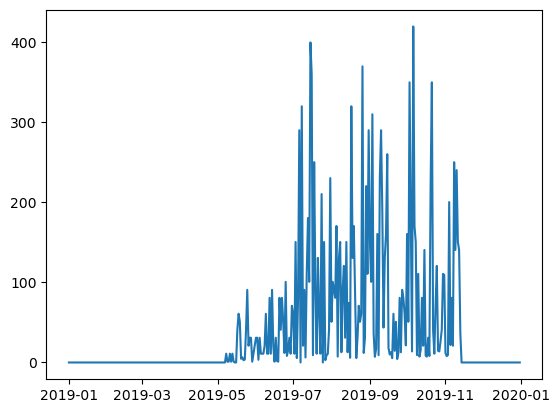

In [16]:
plt.plot(user_2019[non_stationary_idx_list[444]])
plt.show()

Trend removal

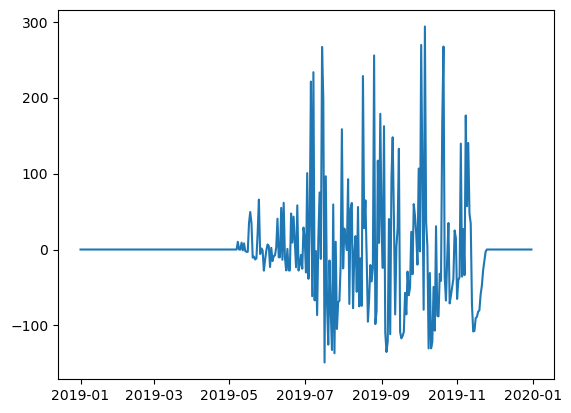

In [17]:
ts_example = user_2019[non_stationary_idx_list[444]]

ts_shift = ts_example - ts_example.rolling(window=12, min_periods=1).mean()
plt.plot(ts_shift)
plt.show()

In [18]:
# Augmented Dickey-Fuller test of example of timeseries after trend removal
# (to provide a quick check and confirmatory evidence that the time series is stationary or non-stationary)
adf = adfuller(ts_shift)
adf, pvalue, critical_values = adf[0], adf[1], adf[4]
print(f"ADF: {adf}\np-value: {pvalue}")
print("Critical values:")
for k, v in critical_values.items():
    print(f"{k}: {v}")

ADF: -5.394945421711191
p-value: 3.470995058865725e-06
Critical values:
1%: -3.449336554273722
5%: -2.8699055166063085
10%: -2.571226758215748


Remove trends for all timeseries with trend

In [19]:
user_2019_detrend = user_2019.copy()

for col in non_stationary_idx_list:
    user_2019_detrend[col] = user_2019_detrend[col] - user_2019_detrend[col].rolling(window=12, min_periods=1).mean()

In [20]:
user_2019_detrend.to_csv('../dataset/time_series_trendless.csv')

### Noise detection
(prova diverse window)

(365,)


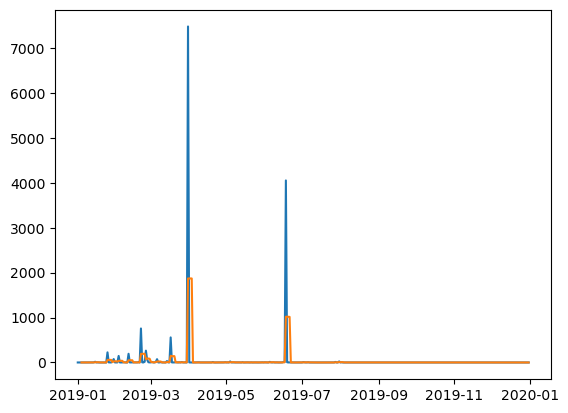

In [140]:
ts_example = user_2019.iloc[:, 29]

print(np.shape(ts_example))

plt.plot(ts_example)
plt.plot(ts_example.rolling(window=4).mean())
plt.show()

To find the best sliding window for the noise we used the mean of the sums of absolute differences between the original timeseries and the smoothed one, then me resorted to the elbow method to choose the best window that 'doesn't smooth too much' the original timeseries.

In [152]:
noise_windows = np.array(range(1,21))

mean_sad_dict = dict()

for window_size in tqdm(noise_windows):
    sum_abs_diff_users = list()

    for user_id in user_2019_detrend.columns:
        sum_abs_diff_single_per_user = np.sum(np.abs(user_2019_detrend[user_id].rolling(window=window_size, center = True, min_periods = 1).mean() - user_2019_detrend[user_id]))
        sum_abs_diff_users.append(sum_abs_diff_single_per_user)
    
    mean_sad_dict[window_size] = np.average(sum_abs_diff_users)

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


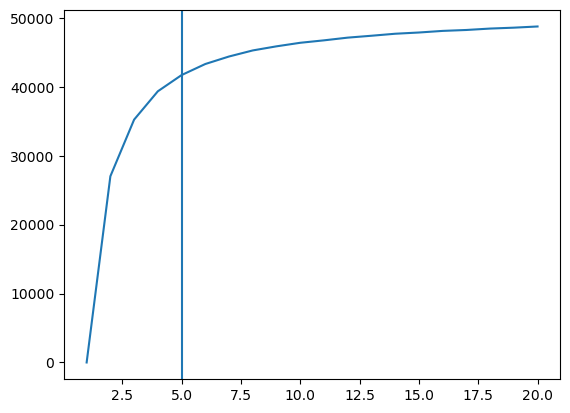

In [153]:
plt.plot(mean_sad_dict.keys(), mean_sad_dict.values())
plt.axvline(5)
plt.show()

The result of this analisys is window size = 5

In [154]:
window_size = 5

In [155]:
def denoiser(df, window_size):
    denoised_df = df.apply(lambda ts : ts.rolling(window=window_size, center = True, min_periods = 1).mean())

    return denoised_df

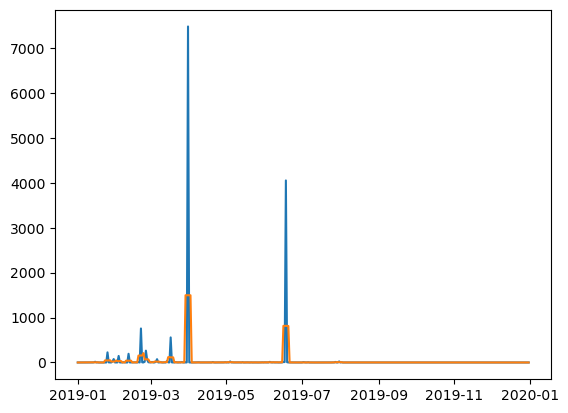

In [156]:
denoised_user_2019 = denoiser(user_2019_detrend,window_size=window_size)
user_id = 29

plt.plot(user_2019.iloc[:, user_id])
plt.plot(denoised_user_2019.iloc[:, user_id])
plt.show()

### Scaler

#### Mean Variance

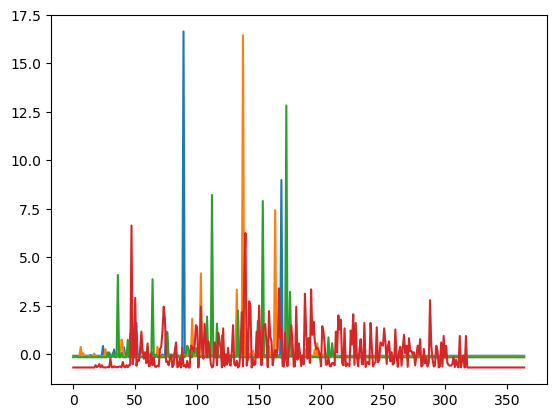

In [22]:
#scaler mean variance
user_2019_std = pd.DataFrame(columns=user_2019_detrend.columns)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  
for col in user_2019_detrend.columns:
    user_2019_std[col] = scaler.fit_transform(user_2019_detrend[col].values.reshape(1, -1)).flatten()

ts_example_1 = user_2019_std.iloc[:, 29]
ts_example_2 = user_2019_std.iloc[:, 567]
ts_example_3 = user_2019_std.iloc[:, 1000]
ts_example_4 = user_2019_std.iloc[:, 867]
plt.plot(ts_example_1)
plt.plot(ts_example_2)
plt.plot(ts_example_3)
plt.plot(ts_example_4)
plt.show()

In [23]:
user_2019_std.head()

,722623,755746,806975,887281,1382561,3888491,5812422,5820222,6296742,6775342,...,2654027174,2658726517,2662897087,2675560628,2680793168,2682782132,2688868016,2711226669,2717999764,2722021425
0,-0.056282,-0.154819,-0.146691,-0.145052,-0.117769,-0.100206,-0.211537,0.002669,-3.311506e-18,-0.177224,...,-0.128572,-0.110069,-0.053284,-0.105263,-0.054392,-0.090488,-0.091035,-0.105493,-0.06147,-0.056357
1,-0.056282,-0.154819,-0.146691,-0.145052,-0.117769,-0.100206,-0.211537,0.002669,-3.311506e-18,-0.177224,...,-0.128572,-0.110069,-0.053284,-0.105263,-0.054392,-0.090488,-0.091035,-0.105493,-0.06147,-0.056357
2,-0.056101,-0.147393,-0.146691,3.522319,0.643268,0.001662,-0.207811,0.127974,-3.311506e-18,-0.177224,...,-0.128572,-0.110069,-0.053284,-0.105263,-0.054392,-0.090488,-0.091035,-0.105493,-0.06147,-0.056357
3,0.059116,-0.147393,-0.146691,-0.145052,-0.099731,-0.100206,-0.191933,1.127263,-3.311506e-18,-0.177224,...,-0.128572,-0.110069,-0.053284,-0.105263,-0.054392,-0.090488,-0.091035,-0.105493,-0.06147,-0.056357
4,-0.056082,-0.147393,-0.146691,-0.145052,-0.100698,-0.100206,-0.208180,-0.345178,-3.311506e-18,0.313106,...,-0.128572,-0.110069,-0.053284,-0.105263,-0.054392,-0.090488,-0.091035,-0.105493,-0.06147,-0.056357


### Resample ??

## Clustering timeseries

In [72]:
from tslearn.clustering import TimeSeriesKMeans
import random


In [96]:
n_clusters = 5
data_array = np.transpose(user_2019_detrend.values)
model = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw',max_iter=10)
model.fit(data_array)

TimeSeriesKMeans(max_iter=10, n_clusters=2)

In [97]:
y = model.predict(data_array)
x = user_2019_detrend.index
user_list = user_2019_detrend.columns.to_list()

c:\Users\Kaos1\anaconda3\envs\dataminingenv\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 6787 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [98]:
np.unique(y,return_counts=True)

(array([0, 1], dtype=int64), array([6786,    1], dtype=int64))

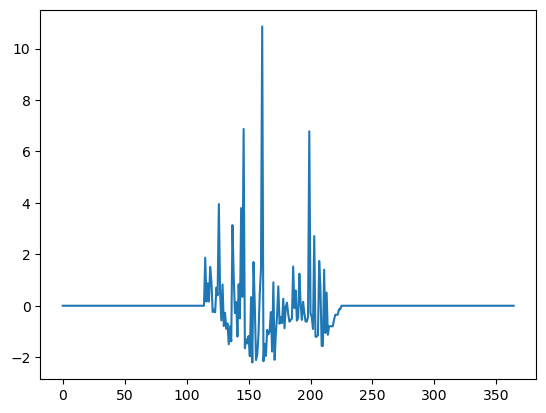

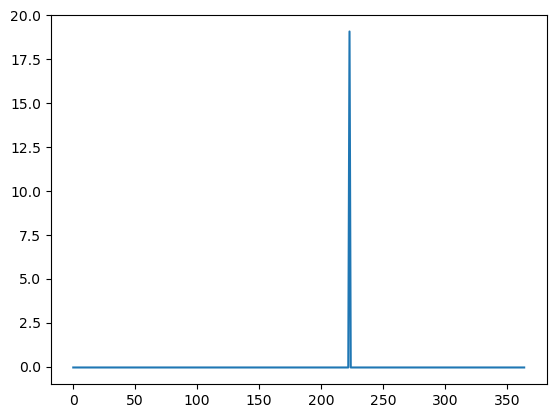

In [99]:
num_samples_per_cluster = 1
for c in range(n_clusters):
    cluster_index = [i for i, x in enumerate(y) if x == c] 
    random_indexes = np.random.choice(cluster_index, size=num_samples_per_cluster, replace=False)
    user_cluster_sample = user_2019_std.iloc[:,random_indexes]
    
    for id in user_cluster_sample.columns:
        plt.plot(user_cluster_sample[id])

    plt.show()
    

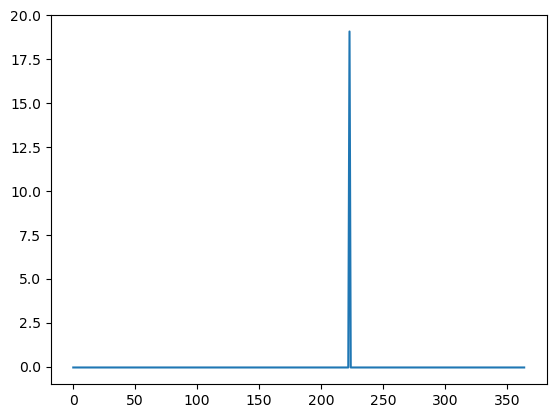

In [83]:
plt.plot(user_2019_std[467158666])
plt.show()

### Hierarchical clustering